In [1]:
# Running on GPU?

import setGPU

setGPU: Setting GPU to: 6


# Monitoring Trigger Rates

In [2]:
import getpass
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline 

In [3]:
# Get pass for EOS

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [7]:
fits = pd.read_csv("./fits_corrected.csv",
                   dtype={"trigger": str,
                          "function": str,
                          "sigma": str,
                          "run": int},
                   index_col=0)

fits.head(1)

,trigger,function,sigma,run
0,AlCa_EcalEtaEBonly,-0.577724010406387+x*(0.062083640099194+ x*(-0...,0.357559041545,304797


In [8]:
def change_sigma(sigma):
    try:
        return eval(sigma)
    except:
        return np.nan

fits.sigma = fits.sigma.apply(change_sigma);
fits.dropna(inplace=True)
fits.sigma = fits.sigma.apply(float)

In [9]:
print("Total number of runs: %s" % len(fits.run.unique()))

Total number of runs: 272


In [19]:
SELECT_RUNS = [300087]

SELECT_TRIGGERS = list(
    set(
        fits[fits.trigger.str.contains("Mu", na=False) & fits.trigger.str.contains("HLT", na=False) &
             (fits.run == SELECT_RUN)].trigger.unique().tolist() + 
        fits[fits.trigger.str.contains("EG", na=False) & fits.trigger.str.contains("HLT", na=False) &
             (fits.run == SELECT_RUN)].trigger.unique().tolist() +
        fits[fits.trigger.str.contains("Ele", na=False) & fits.trigger.str.contains("HLT", na=False) &
             (fits.run == SELECT_RUN)].trigger.unique().tolist()
    )
)

SELECT_TRIGGERS = sorted(SELECT_TRIGGERS)

In [12]:
data = pd.DataFrame()
for _, sample in fits[fits.trigger.isin(SELECT_TRIGGERS)].iterrows():
    
    if sample["run"] != SELECT_RUN:
        continue
    
    # Load rates from .npy
    rates = np.load("/eos/cms/store/cmst3/group/dehep/adpol/trigger/%s/%s.npy" % 
                    (sample["run"], sample["trigger"]))
    
    # Sort rates based on <PU>
    rates_sorted = rates[:,np.argsort(rates[0])]
    
    # Reverse sorting
    rates_sorted_reverse =  np.fliplr(rates_sorted)
    
    # Save rates to dataframe
    sample["rates"] = rates_sorted_reverse
    data = data.append(pd.Series(sample))

## Covariance

In [13]:
import json as json

from itertools import compress
from sklearn import covariance, cluster

In [14]:
# Utilities

def find_common_pu(pileups):
    common_pu = np.array([])
    
    for pu in pileups[0]:
        include = True
        for pus in pileups:
            if pu not in pus:
                include = False
        if include:
            common_pu = np.append(common_pu, pu)
    return common_pu

def eq_seq(ref, rates):
    indexes = []
    for i in range(len(rates)):
        if not rates[i] in ref:
            indexes.append(i)
    return indexes

def normalize_to_prediction(x, function):
    return eval(function.replace('sinh', 'np.sinh'))

def calculate_first_differences(rates):
    seq = []
    for i in range(len(rates)-1):
        seq.append(rates[i + 1] - rates[i])
    return seq

def calculate_link_relatives(rates):
    seq = []
    for i in range(len(rates)-1):
        seq.append(rates[i + 1] / rates[i])
    return seq

In [15]:
def calculate_covariance(runs, triggers, require_modeling=False,
                         first_differences=False, link_relatives=False):

    number_of_triggers = len(triggers)
    covariance_matrix = np.zeros([number_of_triggers, number_of_triggers])
    itterations = 0

    for run in runs:
        if (len(data[data.run == run]) == len(triggers)):
            
            # Change time series to follow the same <pu>
            rates = [r[1] for r in data[data.run == run].rates.values]
            pu = [r[0] for r in data[data.run == run].rates.values]
            
            common_pu = find_common_pu(pu)
            
            for i in range(number_of_triggers):
                indexes = eq_seq(common_pu, pu[i])
                rates[i] = np.delete(rates[i], indexes)
                      
            # De-trending: Substract prediction
            if require_modeling:
                predict = data[data.run == run].function.values
                for i in range(number_of_triggers):
                    rates[i] = rates[i] - normalize_to_prediction(common_pu, predict[i])                   

            # De-trending: Calculate first differences
            if first_differences:
                rates = [calculate_first_differences(r) for r in rates]
            
            # De-trending: Calculate link relatives
            if link_relatives:
                rates = [calculate_link_relatives(r) for r in rates]
                
            var = np.concatenate(rates).reshape(len(triggers), -1)
            X = var.copy().T
            X /= X.std(axis=0)

            #edge_model = covariance.GraphLassoCV()
            #edge_model.fit(X)
            #covariance_matrix = covariance_matrix + edge_model.covariance_

            edge_model = covariance.empirical_covariance(X)
            covariance_matrix = covariance_matrix + edge_model

            itterations += 1
                
    return covariance_matrix / itterations

In [16]:
def plot_covariance(my_covariance):
    fig = plt.figure()
    vmax = my_covariance.max()
    plt.figure(figsize=(24, 14))
    plt.imshow(my_covariance, interpolation='nearest', vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    plt.show()

def export_data_for_d3(cm, cluster, file_name):
    nodes = []
    for trigger, group in zip(SELECT_TRIGGERS, cluster):
        nodes.append({"name": trigger,
                      "group": int(group)})

    links = []
    itter = len(SELECT_TRIGGERS)
    for i in range(itter):
        for j in range(i, itter):
            links.append({"source": i,
                          "target": j,
                          "value": cm[i][j]})

    with open(file_name, "w") as file:
        
        file.write(json.dumps({"nodes": nodes,
                               "links": links}))

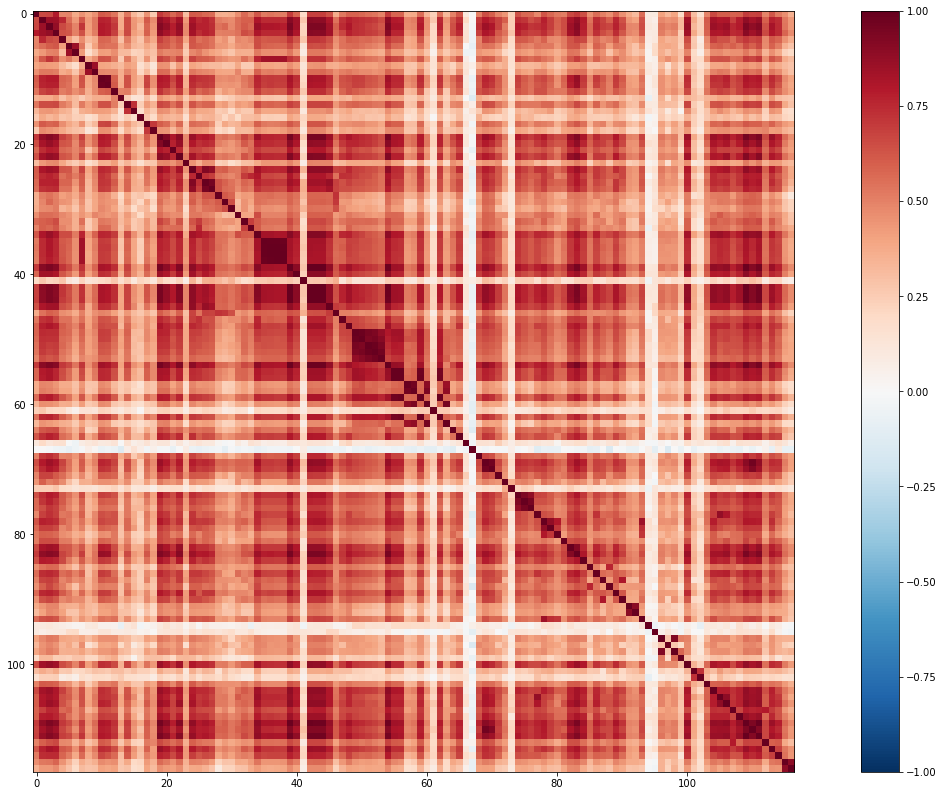

In [30]:
for flags in [(0,0,0), (1,0,0), (0,1,0), (1,1,0), (1,0,1), (1,1,1)]:
    covariance_matrix = calculate_covariance(SELECT_RUNS, SELECT_TRIGGERS, flags[0], flags[1], flags[2])
    _, labels = cluster.affinity_propagation(covariance_matrix)
    json_name = "./data%s.json" % ''.join(str(i) for i in flags)
    export_data_for_d3(covariance_matrix, labels, json_name)
    if set(flags) == {0}:
        plot_covariance(covariance_matrix)

In [32]:
def PlotTrigger(ax, sample):
    x = sample.rates[0]
    prediction = eval(sample.function.replace('sinh', 'np.sinh'))
    smax = prediction + sample.sigma
    smin = prediction - sample.sigma
    
    ax.plot(x, sample.rates[1], 'bo', markersize=2)
    ax.plot(x, prediction, 'r-', alpha=0.5)
    ax.fill_between(x, smax, smin, color='red', alpha=0.2)

for _, sample in data.iterrows():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    PlotTrigger(ax, sample)
    ax.set_title("%s" % (sample.trigger))
    ax.set_ylabel("Rate [Hz]")
    ax.set_xlabel("<PU>")
    plt.savefig('./figures/%s.png' % sample.trigger);
    plt.close(fig)